In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

# from qiskit import *
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, execute, assemble, transpile
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.visualization import plot_state_qsphere, plot_state_city, plot_bloch_multivector
from qiskit.visualization import array_to_latex
import qiskit.quantum_info as qi
# from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_ionq import IonQProvider
# import gates
from qiskit_ionq import GPIGate, GPI2Gate, MSGate
from qiskit import Aer, execute, assemble
from qiskit.providers.jobstatus import JobStatus
import time

from pipeline.qiskit_circuit_constructor import qiskit_alice_prepares, qiskit_measurement_prep, qiskit_clone, construct_qiskit_circuit
from pipeline.ionq_circuit_constructor import ionq_alice_prepares
from pipeline.ionq_circuit_constructor import ionq_measurement_prep
from pipeline.ionq_circuit_constructor import ionq_clone
from pipeline.ionq_circuit_constructor import construct_ionq_circuit
#from pipeline.run_experiments import fidelities
#from pipeline.run_experiments import get_circuit
#from pipeline.run_experiments import run_experiment_ionq
#from pipeline.run_experiments import run_simulation

provider = IonQProvider("2BCQ6XP8m8wN0BPl3KawTCsAwYEBn73F")
#native_simulator = provider.get_backend("ionq_simulator", gateset="native")
native_qpu = provider.get_backend("ionq_qpu", gateset="native")

#ionq_sim = provider.get_backend("ionq_simulator")
#ionq_qpu = provider.get_backend("ionq_qpu")

In [2]:
# Selection of Experiment Parameters
N = 100 # number of randomly selected angles from 0 to pi/4
shots = 100 # number of shots for each input angle
basis = 'X'
bitval = 0
filename = 'Experiment_July16_2023_Native_QPU_FullSize_Xbasis_bit0.csv'


In [3]:
def retrieve_data(job_num, angle, bitval, shot_count):
    ionq = provider.get_backend("ionq_qpu")
    retrieved = ionq.retrieve_job(job_num) 
    counts = retrieved.result().get_counts()
    
    out000 = retrieved.result().get_counts().get("000")
    out001 = retrieved.result().get_counts().get("001")
    out010 = retrieved.result().get_counts().get("010")
    out011 = retrieved.result().get_counts().get("011")
    out100 = retrieved.result().get_counts().get("100")
    out101 = retrieved.result().get_counts().get("101")
    out110 = retrieved.result().get_counts().get("110")
    out111 = retrieved.result().get_counts().get("111")
    
    if out000 == None:
        out000 = 0
    if out001 == None:
        out001 = 0
    if out010 == None:
        out010 = 0
    if out011 == None:
        out011 = 0
        
    if out100 == None:
        out100 = 0
    if out101 == None:
        out101 = 0
    if out110 == None:
        out110 = 0
    if out111 == None:
        out111 = 0
        
    B,E = fidelities(out000, out001, out010, out011, out100, out101, out110, out111, bitval, shot_count)
    
    row_data = [job_num, angle, shot_count, out000, out001, out010, out011, out100, out101, out110, out111, B, E]
        
    return row_data

In [4]:
def fidelities(out000, out001, out010, out011, out100, out101, out110, out111, bitval, shots):
    '''
    This function averages the fidelity of the clones and ancilla over experiment.

    Parameters:
    --------------
    outijk -
    bitval -
    shots - Number of samples.

    Returns:
    --------------
    bob_fidelity - Fidelity of copy sent to intended recipient (Bob).
    eve_fidelity - Fidelity of copy kept by eavesdropper (Eve).
    ancilla_fidelity - Fidelity of the ancilla.
    
    '''
    
    if bitval == 1:
        bob_fidelity = (out001 + out011 + out101 + out111)/shots
        eve_fidelity = (out010 + out011 + out110 + out111)/shots
        #ancilla_fidelity = (out100 + out101 + out110 + out111)/shots
        
    if bitval == 0:
        bob_fidelity = (out010 + out000 + out110 + out100)/shots
        eve_fidelity = (out001 + out000 + out101 + out100)/shots
        #ancilla_fidelity = (out000 + out001 + out010 + out011)/shots
        
    return bob_fidelity, eve_fidelity

In [5]:
def get_circuit(angle, bitval, basis):
    qc = QuantumCircuit(3,3)
    
    qc = ionq_alice_prepares(qc, bitval, basis)
    qc.barrier()
    qc = ionq_clone(qc, angle)
    qc.barrier()
    qc = ionq_measurement_prep(qc, basis)
    
    qc.measure(0,0)
    qc.measure(1,1)
    qc.measure(2,2)
    return qc

In [6]:
def experiment_qpu(angle, bitval, basis, shot_count):
    qc = get_circuit(angle, bitval, basis)
    
    #ionq_qpu = provider.get_backend("ionq_qpu")
    job = native_qpu.run(qc, shots = shot_count)

    job_data = [job.job_id(), angle, bitval, basis, shot_count]
    
    return job_data

In [7]:
# Random selection of angles
def angles(N):
    Angles = np.random.uniform(0, np.pi/4, N)
    Angles = np.sort(Angles)
    return Angles

In [8]:
def record_experiment_setup(filename, Angles, bitval, basis, shots): 
    header = ['Job Number', 'Angle', 'Bit Value', 'Basis', 'Total Shots']

    with open(filename, 'w', encoding = 'UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(header)
    
        for j in range(N):
            job_data = experiment_qpu(Angles[j], bitval, basis, shots)
            writer.writerow(job_data)
            print(job_data)
        
        f.close()  
        
        return 'Complete'

In [9]:
def record_experiment_data(filename, Angles, bitval, shots):
    Jobs_Data = pd.read_csv(filename)
    JobNumbers = Jobs_Data.iloc[:, 0]
    
    header = ['Job Number', 'Angle','Total Shots', '000', '001', '010', '011', '100', '101', '110', '111', 'Bobs Fidelity', 'Eves Fidelity']

    with open(filename, 'w', encoding = 'UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(header)

        for j in range(len(JobNumbers)):
            row_data = retrieve_data(JobNumbers[j], Angles[j], bitval, shots)
            writer.writerow(row_data)

        f.close()
    
    return 'Complete'

In [10]:
def get_data(filename):
    Completed_Job_Data = pd.read_csv(filename)

    JobAngles = Completed_Job_Data.iloc[:, 1]
    BobFidelity = Completed_Job_Data.iloc[:, 11]
    EveFidelity = Completed_Job_Data.iloc[:, 12]

    JobAngles = np.array(JobAngles)
    BobFidelity = np.array(BobFidelity)
    EveFidelity = np.array(EveFidelity)
    
    return  JobAngles, BobFidelity, EveFidelity

In [11]:
def fidelity_curves(JobAngles, BobFidelity, EveFidelity, degree):
    Model_Bob = np.poly1d(np.polyfit(JobAngles, BobFidelity, degree))
    Model_Eve = np.poly1d(np.polyfit(JobAngles, EveFidelity, degree))
    Thetas = np.linspace(0, np.pi/4, 100)
    Model_Bob_Curve = Model_Bob(Thetas)
    Model_Eve_Curve = Model_Eve(Thetas)
    return Thetas, Model_Bob_Curve, Model_Eve_Curve

In [12]:
def QBER_Bob_exp(N, BobFidelity):
    Q = np.ones(N)
    Q = Q - BobFidelity
    return Q

In [13]:
def binary_entropy(t):
    if t == 0 or t == 1:
        return 0
    else:
        return -t * np.log2(t) - (1-t) * np.log2(1-t)

In [14]:
# Mutual information between Alice and Bob
def Info_AB(Q):
    return 1 - binary_entropy(Q)

In [15]:
# Mutual information between Alice and Eve
def Info_AE(Q):
    return 1 - binary_entropy(0.5 - np.sqrt(Q * (1-Q)))

In [16]:
# Calculate the observed mutual information using the fidelities for Bob and Eve
def observed_mutual_info(N, Q):
    IAB_exp = np.zeros(N)
    IAE_exp = np.zeros(N)
    for j in range(N):
        IAB_exp[j] = Info_AB(Q[j])
        IAE_exp[j] = Info_AE(Q[j])
    return IAB_exp, IAE_exp

In [17]:
# A function that calculates the threshold error rate for Alice and Bob
# Error rate
def error_rate_theory(theta):
    return 0.5 - 0.5*np.sin(2 * theta)

In [18]:
# Fitting Curvesfor the mutual information functions and calculate critical error rate and theta2 values
def mutual_info_curves(Angles, IAB_exp, IAE_exp, degree):
    critical_theta = 0.0
    critical_error = 0.0
    
    Model_IAB = np.poly1d(np.polyfit(Angles, IAB_exp, degree))
    Model_IAE = np.poly1d(np.polyfit(Angles, IAE_exp, degree))
    Thetas = np.linspace(0, np.pi/4, 100)
    Model_IAB_curve = Model_IAB(Thetas)
    Model_IAE_curve = Model_IAE(Thetas)
     
    ModelDiff = Model_IAB - Model_IAE
    Roots = np.roots(ModelDiff)
    RealRoots = Roots[~np.iscomplex(Roots)]
    for j in range(len(RealRoots)):
        if RealRoots[j] >= 0 and RealRoots[j] <= np.pi/4:
            critical_theta = RealRoots[j]
            critical_error = error_rate_theory(RealRoots[j])
            #print('theta2 =', RealRoots[j])
            #print('error rate =', error_rate_theory(RealRoots[j]))
    
    return Thetas, Model_IAB_curve, Model_IAE_curve, critical_theta, critical_error
    

In [19]:
def experiment_submit(N, shots, bitval, basis, filename):
    # generate angles
    JobAngles = angles(N)
    
    # record the experiment setup
    print('Experimental Setup')
    record_experiment_setup(filename, JobAngles, bitval, basis, shots)
    
     # record the experimental data
    #print('Recording data from the experiment')
    #record_experiment_data(filename, JobAngles, bitval, shots)
    
    return 'Experiment successfully submitted.'

In [20]:
def analyze_data(filename, degree):
     # get the fidelities
    Angles, BobFidelity, EveFidelity = get_data(filename)
    
    # calculate Bob's QBER
    Q = QBER_Bob_exp(N, BobFidelity)
    
    # get the fidelity curves
    Thetas, Model_Bob_Curve, Model_Eve_Curve = fidelity_curves(Angles, BobFidelity, EveFidelity, degree)
    
    # calculate the observed mutual information
    IAB_exp, IAE_exp = observed_mutual_info(N,Q)
    
    # calculate the mutual information curves and the error rate/critical angle
    Thetas, Model_IAB_Curve, Model_IAE_Curve, critical_theta, critical_error = mutual_info_curves(Angles, IAB_exp, IAE_exp, degree)
    
    return critical_theta, critical_error, Thetas, Model_Bob_Curve, Model_Eve_Curve, Model_IAB_Curve, Model_IAE_Curve, BobFidelity, EveFidelity, IAB_exp, IAE_exp, Angles

In [21]:
experiment_submit(N, shots, bitval, basis, filename)

Experimental Setup
['307a571b-371d-411f-af5e-99277f829bc3', 0.003716027855270234, 0, 'X', 100]
['4754a85f-107e-489d-8694-9302197ec460', 0.0063421308587682974, 0, 'X', 100]
['45b4acdc-42dc-41fa-90e2-96d1a585fd05', 0.00887756550602324, 0, 'X', 100]
['75af285d-62e8-44cc-8924-d5d9d41903a9', 0.01303699479671785, 0, 'X', 100]
['0ede4a72-1ac4-4570-9eb4-d4fa362af084', 0.01969948161334427, 0, 'X', 100]
['0d165be5-d38c-4a09-b8c2-11bd5bd1a51e', 0.0491228242447022, 0, 'X', 100]
['ca748897-5091-4719-b370-77526c701187', 0.05014218795187679, 0, 'X', 100]
['398559da-2581-4167-9e4a-13aeef259479', 0.05492616116406747, 0, 'X', 100]
['0304d0c7-854a-445a-ac38-5ea8664dc250', 0.056890616365467266, 0, 'X', 100]
['947c897e-63a7-4610-a0cd-8385f6ea73f4', 0.0592287925369579, 0, 'X', 100]
['355b8a88-3e1b-4772-842d-c21820646e19', 0.05989334168961121, 0, 'X', 100]
['44f084ff-387d-4f1e-b9c8-df7d9844e05f', 0.06330364928658859, 0, 'X', 100]
['55b89f22-1e16-42a5-8765-c21a82917989', 0.06778713217092504, 0, 'X', 100]
['80

'Experiment successfully submitted.'

In [22]:
Jobs_Data = pd.read_csv(filename)
JobAngles = Jobs_Data.iloc[:, 1]

In [23]:
record_experiment_data(filename, JobAngles, bitval, shots)

'Complete'

In [24]:
critical_theta, critical_error, Thetas, Model_Bob_Curve, Model_Eve_Curve, Model_IAB_Curve, Model_IAE_Curve, BobFidelity, EveFidelity, IAB_exp, IAE_exp, Angles = analyze_data(filename,3)

In [25]:
# values based on the intersection of plotted information curves
print('Critical angle = ', critical_theta)
print('pi/8 = ', np.pi/8)
print('Critical error = ', critical_error)
print('Theoretical prediction = ', 0.5 - 0.25 * np.sqrt(2))

Critical angle =  (0.597220116908856+0j)
pi/8 =  0.39269908169872414
Critical error =  (0.03499496656799872+0j)
Theoretical prediction =  0.1464466094067262


**Fidelity Calculations.** Below we calculate the critical error based on the intersection of the fidelity curves.

In [26]:
def fidelity_curves_intersection(JobAngles, BobFidelity, EveFidelity, degree):
    Model_Bob = np.poly1d(np.polyfit(JobAngles, BobFidelity, degree))
    Model_Eve = np.poly1d(np.polyfit(JobAngles, EveFidelity, degree))
    
    Thetas = np.linspace(0, np.pi/4, 100)
    Model_Bob_curve = Model_Bob(Thetas)
    Model_Eve_curve = Model_Eve(Thetas)
    
    ModelDiff = Model_Bob - Model_Eve
    Roots = np.roots(ModelDiff)
    RealRoots = Roots[~np.iscomplex(Roots)]
    for j in range(len(RealRoots)):
        if RealRoots[j] >= 0 and RealRoots[j] <= np.pi/4:
            critical_theta = RealRoots[j]
            critical_error = error_rate_theory(RealRoots[j])
            #print('theta2 =', RealRoots[j])
            #print('error rate =', error_rate_theory(RealRoots[j]))
    
    
    return critical_theta, critical_error, Thetas, Model_Bob_curve, Model_Eve_curve

In [27]:
JobAngles, BobFidelity, EveFidelity = get_data(filename)

In [28]:
crit_theta, crit_error, Thetas, Model_Bob_curve, Model_Eve_curve = fidelity_curves_intersection(JobAngles, BobFidelity, EveFidelity, 2)

In [29]:
print('Critical angle = ', crit_theta)
print('pi/8 = ', np.pi/8)
print('Critical error = ', crit_error)
print('Theoretical prediction = ', 0.5 - 0.25 * np.sqrt(2))

Critical angle =  0.32558063315534663
pi/8 =  0.39269908169872414
Critical error =  0.19694476861741006
Theoretical prediction =  0.1464466094067262


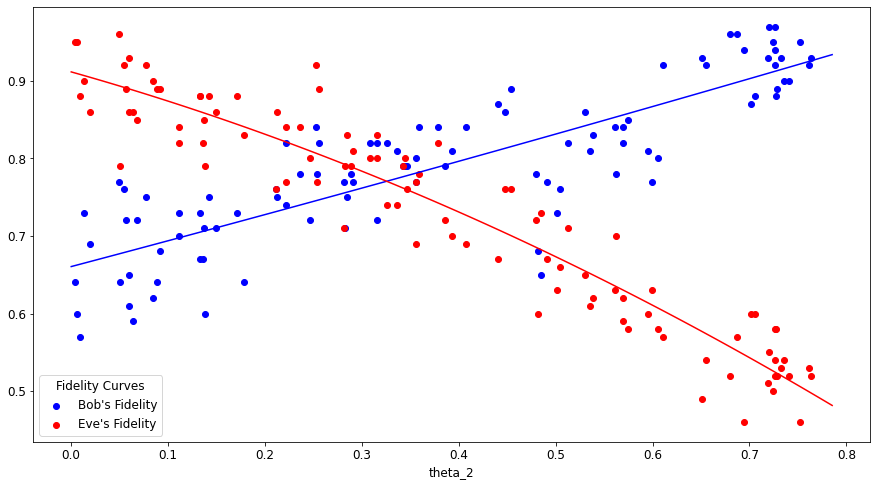

In [30]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 12})
plt.scatter(JobAngles, BobFidelity , label = "Bob's Fidelity",color='blue')
plt.scatter(JobAngles, EveFidelity, label = "Eve's Fidelity",color='red')
plt.plot(Thetas, Model_Bob_curve, color = 'blue')
plt.plot(Thetas, Model_Eve_curve, color = 'red')
#plt.yticks(np.arange(0,1.1, step = .1))
#plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Fidelity Curves")
plt.xlabel('theta_2')
plt.show()